<a href="https://colab.research.google.com/github/HakimFerchichi/ChessGame/blob/main/HakimChess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Creating A Chess AI using Deep Learning**

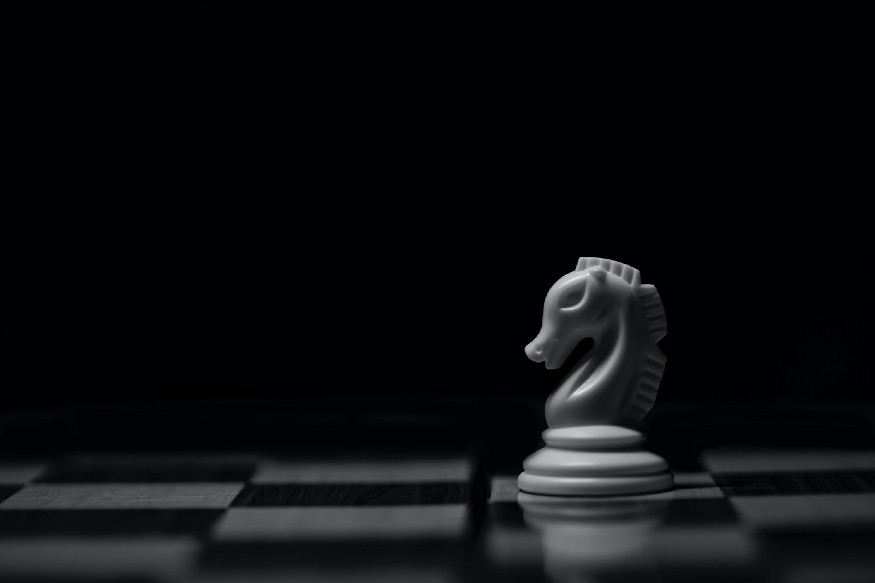
When Gary Kasparov was dethroned by IBM’s Deep Blue chess algorithm, the algorithm did not use Machine Learning, or at least in the way that we define Machine Learning today.
This article aims to use Neural Networks to create a successful chess AI, by using Neural Networks, a newer form of machine learning algorithms.

**Concept:**
Using a chess dataset with over 20,000 instances (contact at ferchichihakim@enicar.u-carthage.tn for dataset), the Neural Network should output a move, when given a chess-board.

In [ ]:
#Step 1| Preparation:
import os
import chess
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

These libraries are the prerequisites to create the program: os and pandas are to access the dataset, python-chess is an “instant” chess-board to test the neural network. Numpy is necessary to perform matrix manipulation. Keras is to create the Neural Network.

In [ ]:
#Step 2| Access Data:
os.chdir('XXXXXXXXXXX')
df = pd.read_csv('chess_normalized.csv')
data = df['moves'].tolist()[:500]
split_data = []
indice = 500

All we need for this project is the pgn of each chessgame from the dataset. Please change the directory path for the os.chdir function to access the directory that the dataset is in.

In [ ]:
#Step 3| One-hot dictionaries:
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}
alpha_dict = {
    'a' : [0,0,0,0,0,0,0],
    'b' : [1,0,0,0,0,0,0],
    'c' : [0,1,0,0,0,0,0],
    'd' : [0,0,1,0,0,0,0],
    'e' : [0,0,0,1,0,0,0],
    'f' : [0,0,0,0,1,0,0],
    'g' : [0,0,0,0,0,1,0],
    'h' : [0,0,0,0,0,0,1],
}
number_dict = {
    1 : [0,0,0,0,0,0,0],
    2 : [1,0,0,0,0,0,0],
    3 : [0,1,0,0,0,0,0],
    4 : [0,0,1,0,0,0,0],
    5 : [0,0,0,1,0,0,0],
    6 : [0,0,0,0,1,0,0],
    7 : [0,0,0,0,0,1,0],
    8 : [0,0,0,0,0,0,1],
}

One-hot encoding is necessary to make sure that no features or certain instances are weighted higher than others, therefore creating a bias in data and hindering the learning of the network. Each move and configuration in the pgn values, is changed into a matrix with a 1 in the appropriate column.

In [ ]:
#Step 4| Preliminary functions to prepare data:
def make_matrix(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo
def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

These two functions are the two preliminary functions to translate the board into ascii form and then into a matrix.

In [ ]:
#Step 5| Create Data:
for point in data[:indice]:
    point = point.split()
    split_data.append(point)
    
data = []
for game in split_data:
    board = chess.Board()
    for move in game:
        board_ready = board.copy()
        data.append(board.copy())
        board.push_san(move)
trans_data = []
for board in data:
    matrix = make_matrix(board)
    trans = translate(matrix,chess_dict)
    trans_data.append(trans)
pieces = []
alphas = []
numbers = []

For the input of the neural network, the board itself is enough: The board itself holds temporal data, although not in the correct order. Adding multiple boards to form temporal data would be too computationally intensive for my poor 8GB of RAM to handle.
Putting the raw input as the moves would remove temporal data and prevent the convolutional layers to extract features from the data. In the first line, the variable indice is optional. I added this variable to decrease the data size to test if the network and the data were functional, before scaling up.

In [ ]:
#Step 6| Transform Data:
true_data = flatten(split_data)
for i in range(len(true_data)):
    try:
        term = flatten(split_data)[i]
        original = term[:]
        term = term.replace('x','')
        term = term.replace('#','')
        term = term.replace('+','')
        if len(term) == 2:
            piece = 'p' 
        else:
            piece = term[0]
        alpha = term[-2]
        number = term[-1]
        pieces.append(chess_dict[piece])
        alphas.append(alpha_dict[alpha])
        numbers.append(number_dict[int(number)])
    except:
        pass

This code removes all instances that cannot be one-hot encoded, by using the try except function and removing all extra notation of a check or a checkmate.
Unfortunately, this means that the program will never learn to castle.

In [ ]:
#Step 7| Creating the Neural Network:
board_inputs = keras.Input(shape=(8, 8, 12))
conv1= layers.Conv2D(10, 3, activation='relu')
conv2 = layers.Conv2D(10, 3, activation='relu')
pooling1 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
pooling2 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
piece_output = layers.Dense(12,name = 'piece')(x)
model_pieces = keras.Model(inputs=board_inputs, outputs=piece_output, name="chess_ai_v3")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_pieces.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=None,
)
model_pieces.fit(trans_data[:len(pieces)],pieces[:len(pieces)],batch_size=64, epochs=100,callbacks = [earlystop])
clear_output()
board_inputs = keras.Input(shape=(8, 8, 12))
conv1= layers.Conv2D(10, 3, activation='relu')
conv2 = layers.Conv2D(10, 3, activation='relu')
pooling1 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
pooling2 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
alpha_output = layers.Dense(7,name = 'alpha')(x)
model_alpha = keras.Model(inputs=board_inputs, outputs=alpha_output, name="chess_ai_v3")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_alpha.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=None,
)
model_alpha.fit(trans_data[:len(alphas)],alphas[:len(alphas)],batch_size=64, epochs=100,callbacks = [earlystop])
clear_output()
board_inputs = keras.Input(shape=(8, 8, 12))
conv1= layers.Conv2D(10, 3, activation='relu')
conv2 = layers.Conv2D(10, 3, activation='relu')
pooling1 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
pooling2 = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None,)
flatten = keras.layers.Flatten(data_format=None)
x = conv1(board_inputs)
x = pooling1(x)
x = conv2(x)
x = flatten(x)
numbers_output = layers.Dense(7,name = 'number')(x)
model_number = keras.Model(inputs=board_inputs, outputs=numbers_output, name="chess_ai_v3")
earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=250, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_number.compile(
    loss=keras.losses.mse,
    optimizer=keras.optimizers.Adam(),
    metrics=None,
)
model_number.fit(trans_data[:len(numbers)],numbers[:len(numbers)],batch_size=64, epochs=100,callbacks = [earlystop])
clear_output()

The Neural Network is a Convolutional Neural Network, with Max Pooling to extract features from the data. This neural network structure is over-laid for each of the three variables to be predicted: The piece, the “alpha” (the column), and the “number” the row.
There are some hard-hitting disadvantages that I could not avoid when designing the Neural Network:
The Neural Network might predict moves that are not legal
The topology of the Neural Network creates a disconnect for predicting each feature
If you think you can solve it, feel free to use this code to better my program!

In [ ]:
#Step 8| Making Predictions:
new_chess_dict = {}
new_alpha_dict = {}
new_number_dict = {}
for term in chess_dict:
    definition = tuple(chess_dict[term])
    new_chess_dict[definition] = term
    new_chess_dict[term] = definition
    
for term in alpha_dict:
    definition = tuple(alpha_dict[term])
    new_alpha_dict[definition] = term
    new_alpha_dict[term] = definition
    
for term in number_dict:
    definition = tuple(number_dict[term])
    new_number_dict[definition] = term
    new_number_dict[term] = definition
data = np.reshape(trans_data[0],(1,8,8,12))
pred = model_pieces.predict(data)
def translate_pred(pred):
    translation = np.zeros(pred.shape)
    index = pred[0].tolist().index(max(pred[0]))
    translation[0][index] = 1
    return translation[0]
piece = translate_pred(model_pieces.predict(data))
alpha = translate_pred(model_alpha.predict(data))
number = translate_pred(model_alpha.predict(data))
piece_pred = new_chess_dict[tuple(piece)]
alpha_pred = new_alpha_dict[tuple(alpha)]
number_pred = new_number_dict[tuple(number)]
move =str(piece_pred)+str(alpha_pred)+str(number_pred)

To decode the predictions from each of the respective neural networks, one must create inverse dictionaries: This means to take the one-hot encodings and translate them into strings. This is detailed by the new_chess_dict, new_alpha_dict and new_number_dict dictionaries created by reversing the term and definition.
With this last bit of code, the program is complete!


**Conclusion:**

The Neural Network, although functional in making predictions, frequently predicts illegal moves, as the range of moves are continuous for ranges of moves that are not legal. I could not create a new solution for this, but thought of a new way to implement a chess AI with a different algorithm: Genetic Algorithms! Stay tuned for that!